In [1]:
!nvidia-smi

Thu Aug 29 04:43:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Total 510 (delta 0), reused 0 (delta 0), pack-reused 510 (from 1)
Receiving objects: 100% (510/510), 88.46 MiB | 36.66 MiB/s, done.
Resolving deltas: 100% (156/156), done.
/content/segment-anything-2


In [4]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [5]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 43.8 MB/s eta 0:00:00


In [6]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [7]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

In [8]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [14]:

# SOURCE_VIDEO = download_assets('cook.mp4')
SOURCE_VIDEO = f"{HOME}/cook.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=3840, height=2160, fps=59, total_frames=682)

In [15]:
SCALE_FACTOR = 0.5
START_IDX = 100
END_IDX = 300

In [16]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

In [17]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 200/200 [00:11<00:00, 16.91it/s]


In [18]:
sam2_model.reset_state(inference_state)

In [19]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [21]:
OBJECTS = ['table', 'closet']

In [23]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

BBoxWidget(classes=['table', 'closet'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564…

widget

In [24]:
widget.bboxes

[{'x': 911, 'y': 1032, 'width': 0, 'height': 0, 'label': 'table'},
 {'x': 1276, 'y': 1030, 'width': 0, 'height': 0, 'label': 'table'},
 {'x': 63, 'y': 1009, 'width': 0, 'height': 0, 'label': 'table'},
 {'x': 170, 'y': 300, 'width': 0, 'height': 0, 'label': 'closet'},
 {'x': 592, 'y': 155, 'width': 0, 'height': 0, 'label': 'closet'}]

In [25]:
default_box = [
    {'x': 705, 'y': 302, 'width': 0, 'height': 0, 'label': 'ball'},
    {'x': 587, 'y': 300, 'width': 0, 'height': 0, 'label': 'player-1'},
    {'x': 753, 'y': 267, 'width': 0, 'height': 0, 'label': 'player-2'},
    {'x': 183, 'y': 282, 'width': 0, 'height': 0, 'label': 'wall'}
]

boxes = widget.bboxes if widget.bboxes else default_box

for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

In [28]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Importing cv2_imshow for Colab

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF']
LABELS = ['table', 'closet']  # Modify labels according to your needs

mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        # Iterate over each detection to extract mask coordinates
        for i, mask in enumerate(detections.mask):
            class_id = detections.class_id[i]
            label = LABELS[class_id - 1]

            # Find the coordinates of non-zero points in the mask
            coordinates = np.column_stack(np.where(mask > 0))

            # Print the mask's coordinates
            print(f"Frame {frame_idx}: {label} - Mask Coordinates:\n {coordinates}")

            # Optionally, draw the mask contour for visualization
            contour_frame = frame.copy()
            for coord in coordinates:
                cv2.circle(contour_frame, tuple(coord[::-1]), 1, (0, 255, 0), -1)  # Drawing points
            # cv2_imshow(contour_frame)
            # cv2.waitKey(1)  # Adjust the delay if needed

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video:   0%|          | 0/200 [00:00<?, ?it/s]

Frame 0: table - Mask Coordinates:
 [[ 926 1272]
 [ 926 1273]
 [ 926 1274]
 ...
 [1077  628]
 [1078  386]
 [1079  386]]
Frame 0: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [930  78]
 [930  79]
 [930  80]]


propagate in video:   0%|          | 1/200 [00:01<05:30,  1.66s/it]

Frame 1: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  626]
 [1079  627]
 [1079  628]]
Frame 1: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [929  48]
 [929  78]
 [929  79]]


propagate in video:   1%|          | 2/200 [00:04<07:34,  2.30s/it]

Frame 2: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 2: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [911  83]
 [911  84]
 [911  85]]


propagate in video:   2%|▏         | 3/200 [00:08<09:35,  2.92s/it]

Frame 3: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 3: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  95]
 [894  96]
 [894  97]]


propagate in video:   2%|▏         | 4/200 [00:10<09:24,  2.88s/it]

Frame 4: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  627]
 [1079  628]
 [1079  629]]
Frame 4: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  96]
 [894  97]
 [894  98]]


propagate in video:   2%|▎         | 5/200 [00:13<09:19,  2.87s/it]

Frame 5: table - Mask Coordinates:
 [[ 926 1267]
 [ 926 1268]
 [ 926 1269]
 ...
 [1079  627]
 [1079  628]
 [1079  629]]
Frame 5: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  96]
 [894  97]
 [894  98]]


propagate in video:   3%|▎         | 6/200 [00:16<09:23,  2.90s/it]

Frame 6: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  627]
 [1079  628]
 [1079  629]]
Frame 6: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  97]
 [894  98]
 [894  99]]


propagate in video:   4%|▎         | 7/200 [00:20<10:23,  3.23s/it]

Frame 7: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  629]
 [1079  630]
 [1079 1451]]
Frame 7: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  96]
 [894  97]
 [894  98]]


propagate in video:   4%|▍         | 8/200 [00:23<10:12,  3.19s/it]

Frame 8: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 8: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  93]
 [894  94]
 [894  95]]


propagate in video:   4%|▍         | 9/200 [00:26<10:02,  3.16s/it]

Frame 9: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 9: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  97]
 [894  98]
 [895  18]]


propagate in video:   5%|▌         | 10/200 [00:29<09:54,  3.13s/it]

Frame 10: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 10: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [895  18]
 [895  19]
 [895  48]]


propagate in video:   6%|▌         | 11/200 [00:34<10:57,  3.48s/it]

Frame 11: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 11: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  99]
 [895  18]
 [895  19]]


propagate in video:   6%|▌         | 12/200 [00:37<10:35,  3.38s/it]

Frame 12: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  630]
 [1079 1450]
 [1079 1451]]
Frame 12: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  99]
 [894 108]
 [895  18]]


propagate in video:   6%|▋         | 13/200 [00:40<10:14,  3.28s/it]

Frame 13: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 13: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894 107]
 [894 108]
 [895  18]]


propagate in video:   7%|▋         | 14/200 [00:43<09:56,  3.21s/it]

Frame 14: table - Mask Coordinates:
 [[ 926 1267]
 [ 926 1268]
 [ 926 1269]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 14: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894  99]
 [894 108]
 [895  18]]


propagate in video:   8%|▊         | 15/200 [00:47<10:30,  3.41s/it]

Frame 15: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 15: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [894 108]
 [895  18]
 [895  19]]


propagate in video:   8%|▊         | 16/200 [00:50<10:15,  3.35s/it]

Frame 16: table - Mask Coordinates:
 [[ 926 1266]
 [ 926 1267]
 [ 926 1268]
 ...
 [1079  628]
 [1079  629]
 [1079  630]]
Frame 16: closet - Mask Coordinates:
 [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [895  19]
 [895  20]
 [895  48]]


propagate in video:   8%|▊         | 16/200 [00:52<10:05,  3.29s/it]


KeyboardInterrupt: 

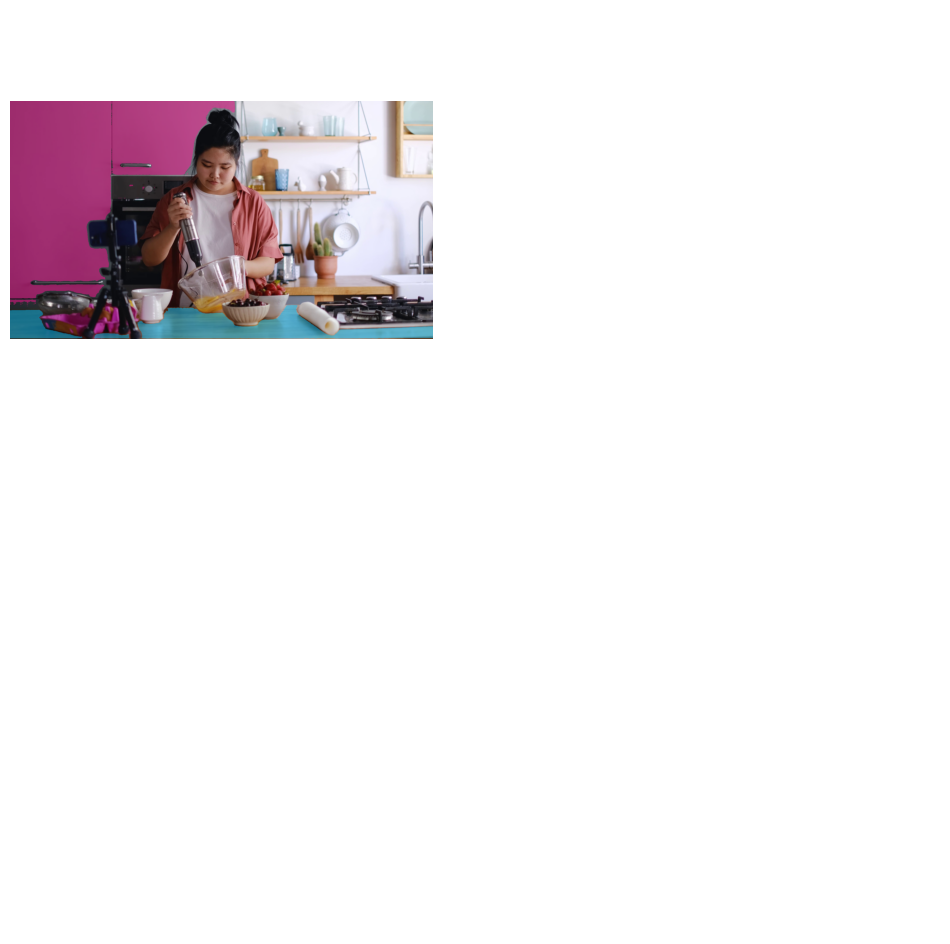

In [29]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)